In [1]:
#SyedHassaanTauqeer 19-01-2019 Final Code Notebook Draft 
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import datetime
import sklearn.cluster as skc
from sklearn.model_selection import train_test_split
from sklearn import svm
import pickle
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fast')
import statsmodels.api as sm
import operator
import matplotlib
%matplotlib inline
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import json

In [2]:
def file_write(df, path, name):
    #This is a simple function that writes a dataframe to a csv file
    return df.to_csv(path+name+'.csv', sep = ';', index = False)#Making index False helps ignore index column when writing file

In [3]:
def floatConv(arr):#This function takes in a python list/ numpy array and replaces any commas left in the thousand position in
    #numerical values. This stands as a safeguard to ensure all values are float for easier future operations
    temp = []
    for i in range(len(arr)):
        temp.append( float(str(arr[i]).replace(",", "") ) )
    return temp

In [4]:
def perScale(arr):#This function is used to scale a list or numpy array to percentage ratio. 
    #This is done by taking the maximum value in that array and scaling every other value relatively. No trailing decimal places
    #left for the sake of ease in matching and querying at future stages
    scaled = []
    tempMax = max(arr)
    for i in range(len(arr)):
        scaled.append( round(float(arr[i]/tempMax)*100, 0) )
    return scaled

In [5]:
def minFil(arrList, win):#This function takes in a list/numpy array and applies a rolling window operation to get the minimum 
    #value within that window. 
    tempDiff = arrList
    appVal = arrList[len(arrList)-1]# To ensure the input and output lengths of the array are same, the last value of the input 
    #array is repeated the number of times that matches one less than the window size
    tempDiff = np.insert(tempDiff, len(tempDiff), np.repeat(appVal, win-1))

    arrListDF = pd.DataFrame({"arr":tempDiff})#since the rolling function in pandas is really efficient, we convert the array
    #to Series data
    tempDiff = arrListDF.rolling(win).min().dropna()#all NaN values are dropped to not cause issues in future operations
    tempDiff = tempDiff['arr'].values
    
    return tempDiff

In [34]:
def diffIndexMaker(arr):#This function takes in an numpy array/list and computes the difference in between each consecutive value
    #To ensure that the input and output lengths of the array remain same, the first value of the array is pre-pended.
    #This doesn't affect the computation or any future operations but keeps length consistent
    temp = arr[0]#.item(0)
    arr = np.insert(arr, 0, temp)#pre-pending the first value to the array
    return np.diff(arr)

In [42]:
def TestPairGen(df):#This function follows the exact same pattern as the training pair generator function
    #It just requires the testing dataframe instead and does not produce a separate label array from the testing pair
    pair = []
    for index, rows in df.iterrows():
        pair.append( ( rows['scaledTime'].astype(float), rows['scaledPower'].astype(float), rows['scaledPowMin'].astype(float), rows['scaledPowDiff'] ) )

    return pair

In [8]:
def thresher(DF):#This is the most important function for the heat phase detection
    #It works on the assumption that the incoming dataframe has three main parts (heat, spin+end and noise)
    #The noise is the most occuring element and becomes an easy target for elimination
    #The spin+endspin is seperated by the sureity that the end always exists in the last time stamps
    #Whatever is left is thus the heating phase
    df = pd.DataFrame({"p": DF['pow'], "time": np.arange(len(DF['pow'].values))})
    x_tag = df['time'].values

    print "length: ", len(df)

    X = df['p'].values.reshape(-1, 1)#single feature re-shaping for cluster prediction - KMeans requires this shape
    model = skc.KMeans(n_clusters=3)#Base assumption that data always has the 3 parts(heat, spin+end and noise)
    y_pred = model.fit_predict(X)

    #dictionary structure to store all predicted cluster labels against respective time stamps
    refTsPowDict = collections.OrderedDict()
    
    for i in range(len(x_tag)):
        refTsPowDict[x_tag[i]] = y_pred[i] #populating dictionary
    
    clustCount = collections.Counter(y_pred)#counting labels to see which labels has how many points
    #this is done because the segments are not always uniformly labelled
    #e.g heat phase might get label '1' in one case and the very next machine iteration may give heat phase a label of '0'
    looper = len(x_tag)
    for  i in range(looper): #deleting noise
        if refTsPowDict[x_tag[i]] == keywithmaxval(clustCount):#gets the cluster key with most frequent value(noise timestamps)
            del refTsPowDict[x_tag[i]]#delete dictionary entry, theeby deleting time stamps of noise
    
    last_key = refTsPowDict.keys()[-1]#possible end spin. Gives the very last time stamp which has to be end spin in theory. 
    H_timeArr = [] #time stamps for heating phase
    comb_timeArr = [] #time stamps for last phases
    for key, value in refTsPowDict.items():
        if value  ==  refTsPowDict[last_key]:#query all dict on this value to get keys for this cluster
            comb_timeArr.append(key)#if query matches then it is from the spin+end group
        else:
            H_timeArr.append(key)#otherwise it's heat
            
    p_val = []
    for i in range(len(H_timeArr)): #create and return dataframe for heat phase
        p_val.append(df[df['time'] == H_timeArr[i]]['p'].values[0])
    hDF = pd.DataFrame({'time': H_timeArr, 'pow':p_val})
    
    return hDF

In [31]:
def keywithmaxval(d): #This function just takes in a dictionary and returns key that corresponds to the maximum value among 
    #the dictionary values
    #for example {A:2, B:6} then the function returns B
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(max(v))]

In [9]:
def binarySegmenter(arr):# This function works with the "Segmenter" function. It's function is to create an array which contains 
    #the time stamps where a positive(where value is 1) prediction occurs. It is used mainly by the predicted vectors. 
    flag = 1#positive prediction
    Seg = []
    for i in range(len(arr)):
        if arr[i]==flag: #phase started
            Seg.append(i)
    return np.asarray(Seg)


def Segmenter(Seg): #This function is very important to find the togetherness of the clustered time stamps and at the same time
    #break up a single segment(timestamp array) which has a huge difference between it's values into separate segments
    #for example a segment/timestamp array is as follows {12, 13,15, 18, 55, 60, 66, 69}
    #this array definitely needs to be broken up in to {12, 13,15, 18} and {55, 60, 66, 69}
    #to segment the labelled predictions. Usable for spins & end spin.
    
    #We also need to see if there are a lot of confident points nearby or if there is a sporadic scatter of timestamps.
    #in this case we need to get rid of them because they will act as noise and result in un-confident labels being considered
    #as actual labels.
    threshold = 3 #minimum number of points in a segment to qualify as a confident prediction/group
    
    # deciding metric to  find breakers in sequence
    #https://www.researchgate.net/post/Can_anybody_suggests_me_how_to_split_a_continuous_variable_into_high_and_low_value_group_for_testing_its_moderating_effect

    diffArr = diffIndexMaker(Seg)#gets the differences between the timestamps
    iqr = np.percentile(diffArr, 75) - np.percentile(diffArr, 25)#inter-quartile range

    count = 0#counts segments
    breakers = []#contains the index of the timestamp where the break occurs

    buff = {}#dictionary that contains the 
    prev = 0 #last marker for subsetting
    for i in range(len(diffArr)):

        if Seg[i] == 0:#only usable in the case of heat phase
            #if the timestamps carry a '0' point that means the heat phase was started at time 't0', which is not
            #possible because a cycle never starts from heat phase on 't0'. This case is only possible if the previous 
            #wash cycle was not completed and carried up in this cycle. We just consider it as an invalid cycle.
            print 'INVALID CYCLE - Previous continuation' 

        else:
            temp = float(diffArr[i])/float(Seg[i])*100
    
            if temp >(float(np.median(diffArr)) + float(iqr)):#filtering on median and inter-quartile range 
            #since data is assumed to be non-centered and un-symmetric

                breakers.append((diffArr[i], i))
                count +=1
            count += 1#this is the number of segments  ---|---|--- in this case breakers=2 and segments=3
    if not breakers: #only one segment

        buff[0]  = Seg[prev:len(Seg)]

    if not (not (breakers)):#ensures that there is at least one breaker which means two segments        
        for i in range(len(breakers)):
            buff[i] = Seg[prev:breakers[i][1]]
            
            if len(Seg[prev:breakers[i][1]])<threshold:#for entries less than thresh utilize the loop
                del buff[i]
                
            prev = breakers[i][1]
               
        buff[len(breakers)] = Seg[prev:len(Seg)]# last segment added manually
        
        if len(Seg[prev:len(Seg)])<threshold:#for entries less than thresh utilize the loop
            del buff[len(breakers)] #entries in segment less confidently predicted are deleted

            # e.g 3 points in a prediction segment are at least required for it to be labeled a separate segment

    return Seg, buff

In [10]:
def gapFinder(_dict, thresh):#This function finds gaps between dictionary entries of segments, which are basically timestamps.
    #If the gaps are big enough it lets them be otherwise it fuses them together to make a shorter dictioanry
    #It works sort of in the opposite manner as the Segmenter function
    #e.g {A:[1,2,4,5,6], B:[10,12,14,17], C:[50,55,59,62]} will become {A:[1,2,4,5,6,10,12,14,17], C:[50,55,59,62]}
    k = _dict.keys()

    if len(k) ==  1: # first case no pre return the only time markers
        return _dict
    else:
        newArr = []
        newDict  = collections.OrderedDict()
        firstPhase = _dict[k[0]] #load initial dictionary

        for i in range(len(k)):
            if i == 0: continue

            tempPrev = firstPhase
            lastPrev  = firstPhase[len(firstPhase)-1]
            tempCurrent = _dict[k[i]]
            firstCurrent = tempCurrent[0]
            gap = firstCurrent  - lastPrev
            # the gap has to be big enough relative to the last point in the previous array
            if ( float(gap)/float(lastPrev) )  < thresh:#acceptible diff means fuse this value with previous and delete this entry

                newArr = np.concatenate((tempPrev, tempCurrent),axis=None)

                firstPhase = newArr #set this as previous

         
            else:
                newDict[i] = tempPrev
                firstPhase = tempCurrent
                
        newDict[k[len(k)-1]+1] = newArr
        
        return newDict

In [12]:
def longestRecKey(_dict):# This function just finds the longest valued array in a dictionary and returns that value array
    _valLen = []
    k = _dict.keys()
    v = _dict.values()
    for items in v: _valLen.append(len(items)) 
    return  _dict[k[_valLen.index(max(_valLen))]]

In [11]:
def preFunc(_dict):#This function analyses the possiblity of a pre-wash cycle existing, in case it does it identifies
    #the markers of the phase
    #Along that it also identifies the main heating phase timestamp array
    _dict = gapFinder(_dict, 0.5)
    preStart, preEnd = 0, 0
    preFlag = False
    k = _dict.keys()
    if len(k) ==  1: # first case no pre return the only time markers
        return preFlag, preStart, preEnd, _dict[k[0]]
    else:
        firstPhase = _dict[k[0]] #load initial dictionary
        longestPhase = longestRecKey(_dict)
        
        if np.array_equal(firstPhase, longestPhase):
            return preFlag, preStart, preEnd, longestPhase
        
        elif _dict.values().index(longestPhase) > _dict.values().index(firstPhase):
            preFlag = True
            preStart = firstPhase[0]
            preEnd  = firstPhase[len(firstPhase)-1]
            return preFlag, preStart, preEnd, longestPhase

In [13]:
def heatAnalysis(_dict, df):#This function takes in the heating phase dataframe that comes after the cluster(KMeans)processing
    #and the dictionary that comes after the segmenting of the heating phase
    #This function provides the markers for the heating phase and the energy calculation by integration to stay precise
    Phase_start, Phase_end = 0, 0 
    Energy = 0

    preFlag, preStart, preEnd, timeArr = preFunc(_dict)

    Phase_start = timeArr[0]
    Phase_end  = timeArr[len(timeArr)-1]

    plt.axvline(x=Phase_start, color='r')
    plt.axvline(x=Phase_end, color='r')

    #The energy is calculated by a simpole formula
    #The power for each of the heat phase timestamps is added
    #The sum is multiplied by 4 because the timestamps have an average difference of 4
    #and divided by 3600 to convert seconds to hours for the energy to be in Watt Hour.
    Energy = float(np.sum(df[df['time'].isin(timeArr)]['pow'].values)) * (float(4)/float(3600))

    return Energy, Phase_start, Phase_end

In [14]:
def endAnalysis(_dict, df):#This function analyses the main dataframe for end cycle information.
    #It also takes in the end cycle prediction vector that has been segmented by the Segmenter function
    #generally assuming that even if more than one end spin detections then the longest one is relevant
    Phase_start, Phase_end = 0, 0
    Energy = 0
    timeArr = longestRecKey(_dict)
    Phase_start = timeArr[0]
    Phase_end  = timeArr[len(timeArr)-1]

    plt.axvline(x=Phase_start, color='g')
    plt.axvline(x=Phase_end, color='g')
    
    #The energy is calculated on the same principle as the heat phase
    #Each 4 second server ping is converted to hours by division by 3600
    #This is then multiplied to the sum of the end phase power sum to give the energy in Watt Hour
    Energy = float(np.sum(df[df['time'].isin(timeArr)]['pow'].values)) * (float(4)/float(3600))

    return Energy, Phase_start, Phase_end

In [15]:
def spinAnalysis(_dict, df):#This function analyses the spins in a single cycle. It requires the main dataframe and the
    #dictionary that results from the segmentation of the spin predicted vector.
    k = _dict.keys()
    Energies = []
    phaseStarts = []#all spin phase starts are stored here
    phaseEnds = []#all spin end phases are stored here
    spins = len(k)#gives the number of spins

    for i in range(spins):
        Energy = 0
        timeArr = _dict[k[i]]

        Phase_start = timeArr[0]
        Phase_end  = timeArr[len(timeArr)-1]
        phaseStarts.append(Phase_start)
        phaseEnds.append(Phase_end)

        plt.axvline(x=Phase_start, color='b')
        plt.axvline(x=Phase_end, color='b')
        
        Energy = float(np.sum(df[df['time'].isin(timeArr)]['pow'].values)) * (float(4)/float(3600))
        Energies.append(Energy)
    #It returns the number of spins, their markers in two lists and their mean energies if more than one spin exist
    return spins, phaseStarts, phaseEnds, np.mean(Energies)

## Testing Phase to begin from here

The test dataframe is read into the notebook.
The models for spin and end spin detection are then loaded in.
A JSON file composed of the entire analysis result is then generated after the analysis runs.

In [20]:
_file = 'C:\\Users\\Labyrinth\\JUPYTER NOTEBOOKS\\WeWash_Praktikum_TUM3sem\WeWash_Analysis_ver2\\Data\\intermediate\\labelled\\test\\UniLabeled_data_50_143200-143324.csv'
labtsDF = pd.read_csv(_file, delimiter=';')
labtsDF.head(2)

,machine,pow,time,spins,end_spin
0,143200,0.07,0,NaN,NaN
1,143200,0.06,1,NaN,NaN


In [21]:
machines = labtsDF['machine'].unique() #Uniques machines are filtered based on id
print 'machines: ', len(machines)

machines:  50


In [22]:
testDF = pd.DataFrame()
for i in range(len(machines)):#Each of the machines has multiple records. 
    tempDF = labtsDF[labtsDF['machine'] == machines[i]]#now that we have a subset of the dataframe filtered on 
    #the machine, we'll add features to it and then append it to the test dataframe.
    tempDF['pow'] = floatConv(tempDF['pow'].values)#float conversions
    tempDF['time'] = floatConv(tempDF['time'].values)#float conversions
    tempDF['scaledPower'] = perScale(tempDF['pow'].values)#percentage scaling
    tempDF['scaledTime'] =  perScale(tempDF['time'].values)#percentage scaling
    tempDF['powMin'] = minFil(tempDF['pow'].values, win=5)#applying minimum filter to main power values
    tempDF['scaledPowMin'] = minFil(tempDF['scaledPower'].values, win=5)#applying minimum filter to scaled power values
    tempDF['scaledPowDiff'] = diffIndexMaker(tempDF['scaledPower'].values)#creating the difference index from scaled power
    testDF = testDF.append(tempDF)
testDF.head(2)

,machine,pow,time,spins,end_spin,scaledPower,scaledTime,powMin,scaledPowMin,scaledPowDiff
0,143200,0.07,0.0,NaN,NaN,0.0,0.0,0.06,0.0,0.0
1,143200,0.06,1.0,NaN,NaN,0.0,0.0,0.06,0.0,0.0


In [23]:
#It is extremely important to fill all NaN values because otherwise it will hamper the testing process
testDF['end_spin'] = testDF['end_spin'].fillna(0.0)
testDF['spins'] = testDF['spins'].fillna(0.0)
testDF['pow'] = testDF['pow'].fillna(0.0)

In [40]:
#Loading the SVM classifiers
_filePath = 'C:\\Users\\Labyrinth\\JUPYTER NOTEBOOKS\\WeWash_Praktikum_TUM3sem\\WeWash_Analysis_ver2\\Models\\50_146_4f\\'
loaded_spinModel = pickle.load(open(_filePath+'spinSVM_50_146_4f.sav', 'rb'))
loaded_endModel = pickle.load(open(_filePath+'endSVM_50_146_4f.sav', 'rb'))

machine# 143200
length:  1014


IndexError: index 0 is out of bounds for axis 0 with size 0

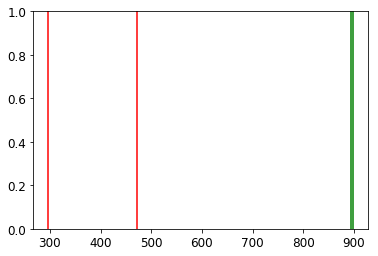

In [41]:
jsonDF  = pd.DataFrame(columns=['mac', 'pre', 'heat', 'spin', 'end', 'avgCycleEnergy'])

for i in range(len(machines)):#THe analysis is run on each machine sample individually
    testSampleDF = testDF[testDF['machine'] == machines[i]]

    print 'machine#', machines[i]
    sample = np.asarray(TestPairGen(testSampleDF))
#     print 'samp: ', sample
    TestPred_spin = loaded_spinModel.predict(sample)
    TestPred_end = loaded_endModel.predict(sample)
 
    
    #1 Check for end
    if np.count_nonzero(TestPred_end)>1:
    #1.1 if not end then invalid cycle
        tempLab, tempBuff = Segmenter(binarySegmenter(TestPred_end))
        
#         #2 If valid then run end analysis
        endDict = {}
        endEnergy, end_start, end_end = endAnalysis(tempBuff, testSampleDF)
        endDict['endEnergy'] = endEnergy
        endDict['end_start'] = end_start
        endDict['end_end'] = end_end
    
        #2.1  segment hDF & run analysis
        hDF = thresher(testSampleDF)
        tempLab, tempBuff = Segmenter(hDF['time'].values)
        #2.2 check pre  && get markers
        preDict = collections.OrderedDict()
        prePhaseFlag, pre_start, pre_end, longestPhase = preFunc(tempBuff)
        preDict['preFlag'] = prePhaseFlag
        preDict['pre_start'] = pre_start
        preDict['pre_end'] = pre_end
            
        #3Run heat analysis
        heatDict = {}
        heatEnergy, heat_start, heat_end = heatAnalysis(tempBuff, hDF)
        heatDict['heatEnergy'] = heatEnergy
        heatDict['heat_start'] = heat_start
        heatDict['heat_end'] = heat_end
        

        #4 segment spins
        tempLab, tempBuff = Segmenter(binarySegmenter(TestPred_spin))
        
        spinDict = {}
        spinNo, spin_start, spin_end, avgSpinEnergy = spinAnalysis(tempBuff, testSampleDF)
        spinDict['spins'] = spinNo
        spinDict['avgEnergy'] = avgSpinEnergy
        for j in range(spinNo):
            spinDict[j+1] = (spin_start[j],  spin_end[j])
            
        #4.1 plot all markers and sample
        plt.plot(np.arange(len(testSampleDF['powMin'].values)), testSampleDF['powMin'].values)

        
        #5 Avg cycle energy
        avgCycEnergy = np.mean(testSampleDF['pow'].values)
        print 'avg energy for cycle: ', avgCycEnergy 
        
        #6 JSON export
        record = []
        record.append(machines[i])
        record.append(preDict)#pre
        record.append(heatDict)#heat
        record.append(spinDict)#spin
        record.append(endDict)#end
        record.append(avgCycEnergy)#avg cycle energy
        jsonDF.loc[len(jsonDF)] = record

        
    plt.show()
    print '\n'